### IMPORTING LIBRARIES AND DATASET

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from matplotlib import pyplot as plt

In [ ]:
! pip upgrade plotly

ERROR: unknown command "upgrade"


In [ ]:
# importing the dataset into the notebook
df = pd.read_csv('/content/Portugese Bank Data - TRAIN.csv', header=0, sep=',')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### EDA

In [ ]:
# looking for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [ ]:
# looking at the balance of the data
df['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [ ]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
px.histogram(df, 'y', facet_row='default', template='plotly_dark')

In [ ]:
px.histogram(df, 'y', facet_col='job', template='plotly_dark')

In [ ]:
px.histogram(df, 'y', facet_col='loan', template='plotly_dark')

In [ ]:
px.histogram(df, 'y', facet_col='poutcome', template='plotly_dark')

In [ ]:
px.histogram(df, 'y', facet_col='month', template='plotly_dark')

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [ ]:
numerical_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['deposit']))]
print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
df[numerical_features].head()

Number of numerical variables:  7


,age,balance,day,duration,campaign,pdays,previous
0,30,1787,19,79,1,-1,0
1,33,4789,11,220,1,339,4
2,35,1350,16,185,1,330,1
3,30,1476,3,199,4,-1,0
4,59,0,5,226,1,-1,0


In [ ]:
numerical_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [ ]:
df[numerical_features].describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('age', 'balance'))

fig.add_trace(go.Box(y=df['age'], name="AGE"), row=1, col=1)
fig.add_trace(go.Box(y=df['balance'],name="BALANCE"), row=1, col=2)
fig.update_layout(template='plotly_dark', showlegend=False)

In [ ]:
df['pdays'].value_counts()

-1      3705
 182      23
 183      20
 363      12
 92       12
        ... 
 118       1
 386       1
 63        1
 81        1
 234       1
Name: pdays, Length: 292, dtype: int64

- from the EDA done above we see that most of the catagorical variables follow a similar pattern
- however, for the column 'default' it is observed that most of the entries are in one catagory so we can treat as a constant and drop it from the dataset
- from the analysis of numeric variables it is clear that for 'pdays' variable there are many entries(approx. 37000) with -1 so we can drop it
- the age is in range of 18-95 with a few outliers which makes sense 
- there are a lot of outliers in balance column but they are the true balance values and they do help the model so there is no need to change them

In [ ]:
df.drop(['default', 'pdays'], axis=1, inplace=True)
df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,30,unemployed,married,primary,1787,no,no,cellular,19,oct,79,1,0,unknown,no
1,33,services,married,secondary,4789,yes,yes,cellular,11,may,220,1,4,failure,no
2,35,management,single,tertiary,1350,yes,no,cellular,16,apr,185,1,1,failure,no
3,30,management,married,tertiary,1476,yes,yes,unknown,3,jun,199,4,0,unknown,no
4,59,blue-collar,married,secondary,0,yes,no,unknown,5,may,226,1,0,unknown,no


In [ ]:
df2=df
df2.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,30,unemployed,married,primary,1787,no,no,cellular,19,oct,79,1,0,unknown,no
1,33,services,married,secondary,4789,yes,yes,cellular,11,may,220,1,4,failure,no
2,35,management,single,tertiary,1350,yes,no,cellular,16,apr,185,1,1,failure,no
3,30,management,married,tertiary,1476,yes,yes,unknown,3,jun,199,4,0,unknown,no
4,59,blue-collar,married,secondary,0,yes,no,unknown,5,may,226,1,0,unknown,no


In [ ]:
cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
for col in  cat_columns:
    df2 = pd.concat([df2.drop(col, axis=1),pd.get_dummies(df2[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=False)], axis=1)

In [ ]:
df2.head()

In [ ]:
bool_columns = ['housing', 'loan', 'y']
for col in  bool_columns:
    df2[col+'_new']=df2[col].apply(lambda x : 1 if x == 'yes' else 0)
    df2.drop(col, axis=1, inplace=True)

In [ ]:
df2.head()

,age,balance,day,duration,campaign,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,housing_new,loan_new,y_new
0,30,1787,19,79,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,33,4789,11,220,1,4,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,35,1350,16,185,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,30,1476,3,199,4,0,0,0,0,1,...,0,0,0,0,0,0,1,1,1,0
4,59,0,5,226,1,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0


In [ ]:
X_train=df2.drop('y_new', axis=1)
y_train=df2['y_new']

In [ ]:
df_test=pd.read_csv('/content/Portugese Bank Data - TEST.csv')

In [ ]:
df_test.drop(['default', 'pdays'], axis=1, inplace=True)
cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
for col in  cat_columns:
    df_test = pd.concat([df_test.drop(col, axis=1),pd.get_dummies(df_test[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=False)], axis=1)
bool_columns = ['housing', 'loan', 'y']
for col in  bool_columns:
    df_test[col+'_new']=df_test[col].apply(lambda x : 1 if x == 'yes' else 0)
    df_test.drop(col, axis=1, inplace=True)
df_test.head()

,age,balance,day,duration,campaign,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,housing_new,loan_new,y_new
0,58,2143,5,261,1,0,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0
1,44,29,5,151,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
2,33,2,5,76,1,0,0,1,0,0,...,1,0,0,0,0,0,1,1,1,0
3,47,1506,5,92,1,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
4,33,1,5,198,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
X_test = df_test.drop('y_new', axis=1)
y_test = df_test['y_new']

### Model Building and Hyperparameter Tuning

In [ ]:
# building random forest classifier and training on the data
from sklearn.model_selection import cross_val_score
model_score =cross_val_score(estimator=RandomForestClassifier(),X=X_train, y=y_train, cv=5)
print(model_score)
print(model_score.mean())

[0.8961326  0.89933628 0.8960177  0.89823009 0.90044248]
0.8980318290715299


In [ ]:
# building decision tree classifier and training on the data
model_score_dt =cross_val_score(estimator=DecisionTreeClassifier(),X=X_train, y=y_train, cv=5)
print(model_score_dt)
print(model_score_dt.mean())

[0.84751381 0.86061947 0.86504425 0.86061947 0.85176991]
0.8571133818999657


In [ ]:
# setting up for hyper parameter tuning
model_param = {
    'RandomForestClassifier':{
        'model':RandomForestClassifier(),
        'param':{
            'n_estimators': [10, 50, 100, 130], 
            'criterion': ['gini', 'entropy'], 
            'max_features': ['auto', 'log2']
        }
    },
    'DecisionTreeClassifier':{
        'model':DecisionTreeClassifier(random_state=42),
        'param':{
           'max_depth': [4,6,8],
            'criterion': ['gini', 'entropy']
        }
    }
}

In [ ]:
# running the grid search cv for both the models and recording the scores
scores =[]
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp['model'],param_grid=mp['param'] , scoring='roc_auc', cv=3, return_train_score=False)
    model_selection.fit(X_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })    

In [ ]:
# printing out the scores of each model
pd.set_option('display.max_columns', None)
best_model_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
best_model_df

,model,best_score,best_params
0,RandomForestClassifier,0.902848,"{'criterion': 'entropy', 'max_features': 'auto..."
1,DecisionTreeClassifier,0.832290,"{'criterion': 'entropy', 'max_depth': 4}"


In [ ]:
# function to plot roc
def plot_roc(predictions):
    fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    plt.clf()
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

In [ ]:
# basic decison tree score
dt1 = DecisionTreeClassifier(random_state=42)
dt1.fit(X_train, y_train)
dt1_prob = dt1.predict_proba(X_test)
roc_auc_score(y_test, dt1_prob[:,1])

0.7136949998232989

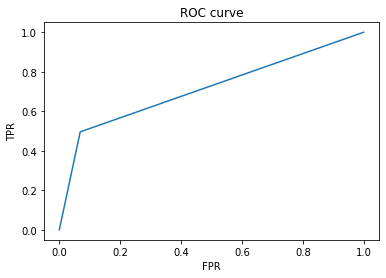

In [ ]:
plot_roc(dt1_prob)

In [ ]:
# tuned decision tree score
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
dt2.fit(X_train, y_train)
dt2_prob = dt2.predict_proba(X_test)
roc_auc_score(y_test, dt2_prob[:,1])

0.8521197446762538

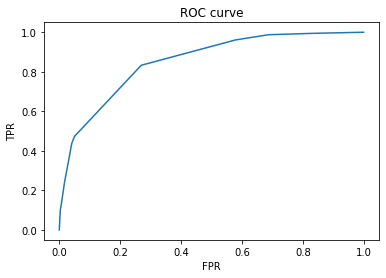

In [ ]:
plot_roc(dt2_prob)

In [ ]:
# base random forest score
rf1 = RandomForestClassifier(random_state=42)
rf1.fit(X_train,y_train)
rf1_prob = rf1.predict_proba(X_test)
roc_auc_score(y_test, rf1_prob[:,1])

0.925685224209519

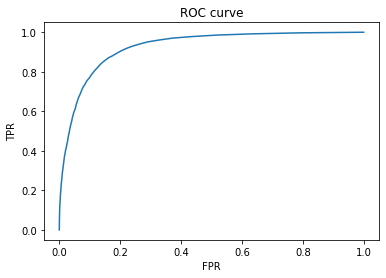

In [ ]:
plot_roc(rf1_prob)

In [ ]:
# tuned random forest score
rf2 = RandomForestClassifier(criterion='entropy', max_features='auto', n_estimators=130, random_state=42)
rf2.fit(X_train,y_train)
rf2_prob = rf2.predict_proba(X_test)
roc_auc_score(y_test, rf2_prob[:,1])

0.9298041040115197

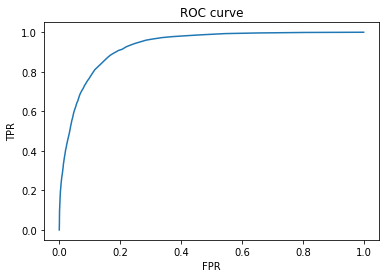

In [ ]:
plot_roc(rf2_prob)